In [1]:
import pandas as pd
import numpy as np
from DRWCryptoTrain import DRWCryptoTrain
from DRWCryptoPrediction import DRWCryptoPrediction

In [2]:
def reduce_mem_usage(dataframe, dataset):    
    print('Reducing memory usage for:', dataset)
    initial_mem_usage = dataframe.memory_usage().sum() / 1024**2

    for col in dataframe.columns:
        col_type = dataframe[col].dtype

        c_min = dataframe[col].min()
        c_max = dataframe[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                dataframe[col] = dataframe[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                dataframe[col] = dataframe[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                dataframe[col] = dataframe[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                dataframe[col] = dataframe[col].astype(np.int64)
        else:
            # if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
            #     dataframe[col] = dataframe[col].astype(np.float16)
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                dataframe[col] = dataframe[col].astype(np.float32)
            else:
                dataframe[col] = dataframe[col].astype(np.float64)

    final_mem_usage = dataframe.memory_usage().sum() / 1024**2
    print('--- Memory usage before: {:.2f} MB'.format(initial_mem_usage))
    print('--- Memory usage after: {:.2f} MB'.format(final_mem_usage))
    print('--- Decreased memory usage by {:.1f}%\n'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

    return dataframe

In [3]:
train_df = pd.read_parquet('inputs/train.parquet')
train_df = reduce_mem_usage(train_df, 'train_df')
train_drw = DRWCryptoTrain(train_df)

Reducing memory usage for: train_df
--- Memory usage before: 3157.59 MB
--- Memory usage after: 1580.80 MB
--- Decreased memory usage by 49.9%



Feature engineering completed.
Train-Eval split completed: 439486 rows for training, 86400 rows for evaluation
Standardizing features
Mean across X-features (abs avg): 4.996554e-09
Std across X-features (avg): 1.0000011
Dropped zero-variance columns: []
=== Target Statistics ===
Mean: 0.025048
Std: 0.998176
Skewness: -0.14
Kurtosis: 17.62
Min: -24.416615, Max: 20.740271
Negative values: 215822 | Zero values: 0 | Positive values: 223664


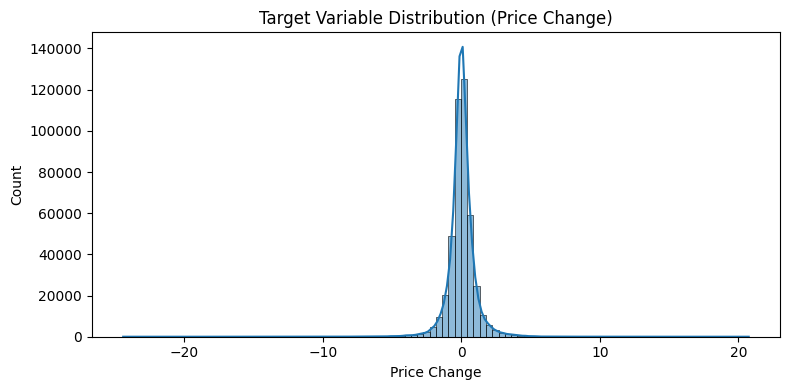

ADF Statistic: -59.1146
p-value: 0.0000
=> Stationary
Loaded exisiting stationary df from inputs/x_stability.csv
Loaded existing correlation matrix from inputs/x_corr_matrix_pearson.csv
Loaded exisiting predictive power df from inputs/x_predictive_power.csv
Dropped 381 columns based on stationarity: ['X102', 'X108', 'X114', 'X120', 'X126', 'X130', 'X132', 'X136', 'X138', 'X139', 'X144', 'X150', 'X156', 'X162', 'X166', 'X168', 'X17', 'X172', 'X174', 'X178', 'X180', 'X184', 'X185', 'X187', 'X188', 'X190', 'X191', 'X196', 'X197', 'X198', 'X199', 'X200', 'X201', 'X202', 'X203', 'X204', 'X205', 'X206', 'X207', 'X208', 'X209', 'X210', 'X211', 'X212', 'X219', 'X226', 'X227', 'X233', 'X25', 'X256', 'X264', 'X272', 'X280', 'X281', 'X282', 'X283', 'X284', 'X285', 'X286', 'X287', 'X288', 'X289', 'X290', 'X291', 'X292', 'X293', 'X294', 'X295', 'X296', 'X297', 'X298', 'X299', 'X300', 'X301', 'X302', 'X303', 'X305', 'X307', 'X308', 'X311', 'X313', 'X314', 'X317', 'X319', 'X320', 'X323', 'X325', 'X32

In [4]:
train_drw.create_market_microstructure_features()
train_drw.split_train_eval()
train_drw.standardize_features_train_eval()
train_drw.check_standardised_features()
train_drw.analyse_variance()
train_drw.explore_target_variable()
train_drw.check_time_series_stability('x_stability')
train_drw.generate_correlation_matrix('x_corr_matrix', 'pearson')
train_drw.generate_predictive_power_df('x_predictive_power')
to_drop_features_1 = train_drw.drop_nonstationary_x()
to_drop_features_2 = train_drw.drop_highly_correlated_features(0.65, to_drop_features_1)
n_components = train_drw.create_pca_features(to_drop_features_2)
X_features = train_drw.X_train.columns
xgb_model = train_drw.train_xgboost('all', X_features)
ridge_model = train_drw.train_ridge('all', X_features)
lgb_model = train_drw.train_lightgbm('all', X_features)
linear_model = train_drw.train_linear('all', X_features)
combined_model = train_drw.combine_models()
train_drw.save_prediction_df()

In [5]:
test_df = pd.read_parquet('inputs/test.parquet')
test_df = reduce_mem_usage(test_df, 'test_df')
test_drw = DRWCryptoPrediction(test_df, train_drw.pca, train_drw.standard_scaler)

Reducing memory usage for: test_df
--- Memory usage before: 3227.13 MB
--- Memory usage after: 1612.02 MB
--- Decreased memory usage by 50.0%



In [6]:
test_drw.create_market_microstructure_features()
test_drw.create_X_test_df()
test_drw.standardize_features()
test_drw.check_standardised_features()
test_drw.create_pca_features(to_drop_features_2, n_components)
test_drw.drop_features(to_drop_features_1 & to_drop_features_2)
test_drw.predict('all', X_features)
test_drw.save_prediction_df()
test_drw.create_submission_file('v1')

Feature engineering completed.
Created X_test dataframe
Standardizing features
Mean across X-features (abs avg): 0.19458909456068804
Std across X-features (avg): 1.262553397349654


c:\Users\chuac\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


PCA added 48 components to X_test.
Completed predictions
